In [1]:
from skimage.transform import resize
import random
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# Catch Environment (from the assignment code)
from Catch import CatchEnv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten



c:\Users\danie\miniconda3\envs\footballtracking\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Memory buffer, to store the trajectories

In [2]:

from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class MemoryBuffer(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity) # iterable deque data structure

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Make a Deep Q-Network

In [20]:

# the network should have 3 outputs, one for each of the possible moves

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sara's one
class DQN(nn.Module):

    def __init__(self, number_of_actions):
        super(DQN, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # conv layers
        self.conv1 = torch.nn.Conv2d(4, 32, 8, stride=4)   # modify input shape to match your input data size
        self.conv2 = torch.nn.Conv2d(32, 64, 4, stride=2)
        #self.conv3 = torch.nn.Conv2d(64, 64, 3)
        # fully connected layers
        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, number_of_actions)


        # mat1 and mat2 shapes cannot be multiplied (8x1024 and 16x512)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        #print('doing conv3')
        #x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
# Dan's attempts to tune things
class DQN(nn.Module):
    def __init__(self, number_of_actions):
        super(DQN, self).__init__()
        # conv layers
        self.conv1 = torch.nn.Conv2d(4, 32, 5, stride=3)   # modify input shape to match your input data size
        self.conv2 = torch.nn.Conv2d(32, 64, 3, stride=2)
        # fully connected layers
        self.fc1 = torch.nn.Linear(576, 128)
        self.fc2 = torch.nn.Linear(128, number_of_actions)


        # mat1 and mat2 shapes cannot be multiplied (8x1024 and 16x512)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        #print('doing conv3')
        #x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    


# A model that is tiny, but runs much faster (for testing the code without waiting to train a good model)
class speedyDQN(nn.Module):

    def __init__(self, number_of_actions):
        super(speedyDQN, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # conv layers
        self.conv1 = torch.nn.Conv2d(4, 16, 5, stride=3)   # modify input shape to match your input data size
        # fully connected layers
        #self.fc1 = torch.nn.Linear(6400, 128)
        self.fc2 = torch.nn.Linear(2704, number_of_actions)



    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        #print('doing conv3')
        #x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        #x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [21]:
class Agent(object):
    def __init__(self, num_moves, eps_start, eps_min, eps_decay, memory, batch_size, optimizer, gamma):
        self.gamma = gamma
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.memory = memory
        self.num_moves = num_moves
        self.epsilon = eps_start
        self.eps_start = eps_start
        self.eps_min = eps_min
        self.eps_decay = eps_decay

        self.episode = 0

        self.model = DQN(num_moves).to(device)
        self.target_network = DQN(num_moves).to(device)
        self.target_network.load_state_dict(self.model.state_dict())
        #self.target_network

        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)

    def select_action(self, state): 
        if np.random.rand() <= self.epsilon:
            return torch.tensor([[random.randrange(self.num_moves)]], device=device, dtype=torch.long)

        q_values = self.model(state)
        action = q_values.max(1)[1].view(1, 1)

        return action # returns a tensor of shape [[n]] (where n is the action number)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)


        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute the Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.model.parameters(), 100)
        self.optimizer.step()

        self.update_eps()


    def update_eps(self):
        if self.epsilon > self.eps_min:
            self.epsilon = self.eps_start * np.exp(-self.episode/self.eps_decay)
            #print(self.eps)
            if self.epsilon < self.eps_min:
                self.epsilon = self.eps_min


    def overwrite_target_network(self):
        self.target_network.load_state_dict(self.model.state_dict())

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)

## Loops

In [22]:
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


plt.ion()


def learningPlotter(episodeNumber, avgReward, show_result=False):
    plt.figure(1)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(episodeNumber, avgReward)
    # Take 100 episode averages and plot them too

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


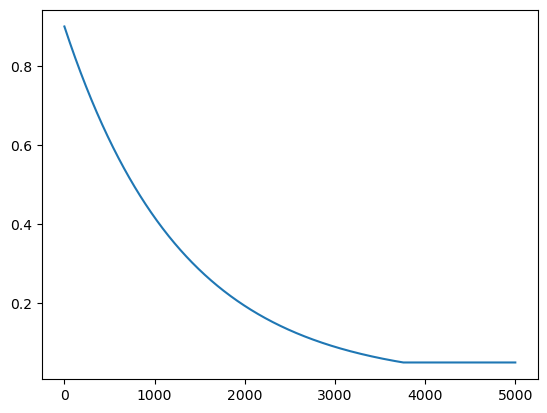

In [23]:
# to see what the decay of epsilon would look like
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1300 # higher value = slower decay

episodes = np.linspace(0, 5000, 1000) # 5,000 episodes

eps_threshold = EPS_START * np.exp(-episodes / EPS_DECAY)
eps_threshold[eps_threshold < EPS_END] = EPS_END

plt.plot(episodes, eps_threshold)

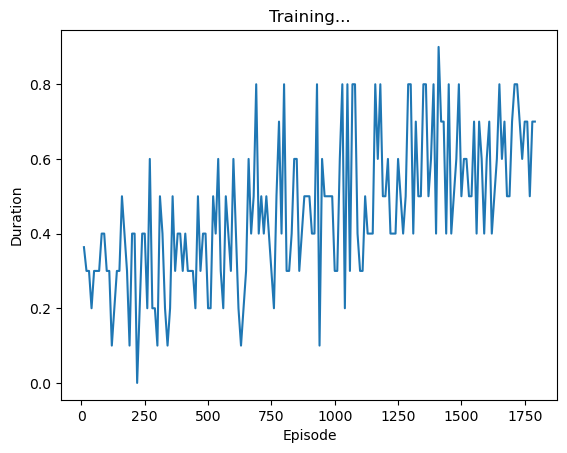

<Figure size 640x480 with 0 Axes>

In [24]:

if torch.cuda.is_available():
    num_episodes = 5000
else:
    num_episodes = 50

env = CatchEnv()


BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1400
#TAU = 0.005
LR = 1e-4
memoryBuffer = MemoryBuffer(1000)
""" this doesn't get used anyway, its defined inside of the agent """
#optimizer = optim.AdamW(policy_network.parameters(), lr=LR, amsgrad=True)
optimizer = None

num_moves = env.get_num_actions()

agent = Agent(num_moves, EPS_START, EPS_END, EPS_DECAY, memoryBuffer, BATCH_SIZE, optimizer, GAMMA)

episodeNumber = []
avgReward = []
tempReward = []



for episode in range(num_episodes):
    agent.episode += 1

    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device)
    state = state.permute(2, 0, 1).unsqueeze(0) # get into the dimension [1,4,84,84] by rearranging from [84,84,4] and unsqueezing to add the 1

    
    terminal = False
    total_reward = 0
    while not terminal:
        # agent interacts with the environment
        action = agent.select_action(state)    
        next_state, reward, terminal = env.step(action.item())  # .item() just uses the value inside of the tensor
        
        reward = torch.tensor([reward], device=device)

        if not terminal:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
            next_state = next_state.permute(2, 0, 1).unsqueeze(0)
        
        if terminal:
            next_state = None
            tempReward.append(reward.item())
            #print('hi')

            # Update the target network
            if episode % 10 == 0 and episode > 0: ## MAYBE USE THE AGENTS FUNCTION
                #print('bye')
                agent.overwrite_target_network()  # update the target newtwork every 10 episodes
                
                # for plotting some average results
                episodeNumber.append(episode)
                avgReward.append(sum(tempReward)/len(tempReward))
                tempReward = []

                 # plot while learning!
                learningPlotter(episodeNumber, avgReward)
                

        # add trajectory to memory buffer
        agent.memory.push(state, action, next_state, reward)

        # Update the total reward
        total_reward += reward.item()
        # move onto the next state
        state = next_state

        # Sample a batch of transitions from the replay buffer
        agent.replay()




print('Complete')
learningPlotter(episodeNumber, avgReward, show_result=True)
plt.ioff()
plt.show()
#display.clear_output(wait=True)

    #print ("End of the episode")
    #print ("  Reward obtained by the agent : {}". format(total_reward))

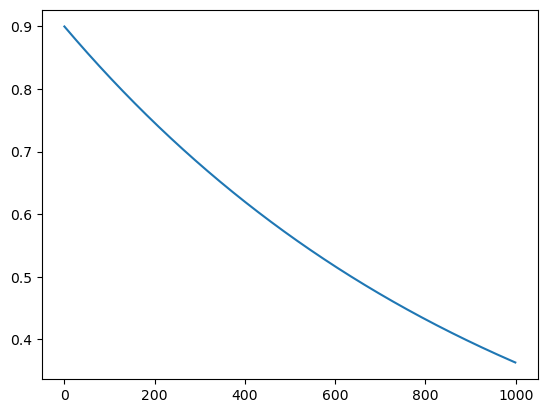

In [ ]:
steps = list(np.arange(0, 1000))

eps_threshold = [EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * step / 1000) for step in steps]

plt.plot(steps, eps_threshold)

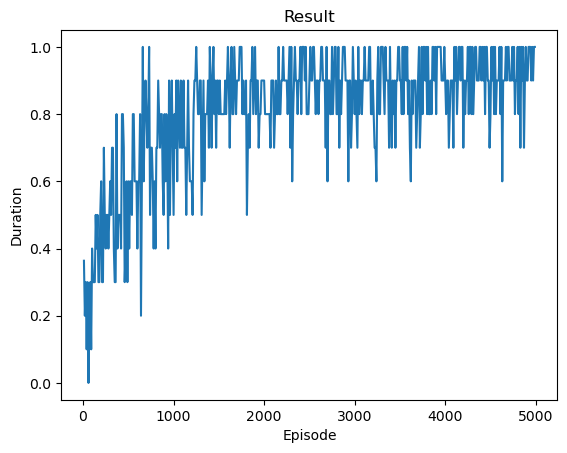

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
learningPlotter(episodeNumber, avgReward, show_result=True)
plt.ioff()
plt.show()

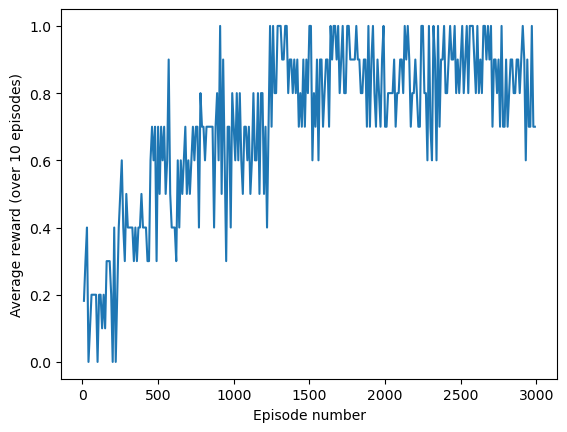

In [ ]:
plt.plot(episodeNumber, avgReward)
plt.ylabel('Average reward (over 10 episodes)')
plt.xlabel('Episode number')
plt.show()

arquitectures for the grid search